Variables of filenames

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/inz/jupyter/'
fileName = directory + 'PlainTree2.5M_ml_DCM_12gev.root'
# fileName = directory + 'PlainTree10K_ml_DCM_12gev.root'
fileNameTest = directory + 'PlainTree1M_ml_URQMD_12gev.root'
# fileNameTest = directory + 'PlainTree10k_ml_DCM_12gev.root'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
#from hipe4ml.model_handler import ModelHandler
#from hipe4ml.tree_handler import TreeHandler
from matplotlib.patches import ConnectionPatch
from matplotlib.backends.backend_pdf import PdfPages
#from hipe4ml import plot_utils

import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import cross_val_score
import scipy
from scipy.stats import uniform

from numpy import sqrt, log, argmax

import weakref 
import itertools

from bayes_opt import BayesianOptimization
# from bayes_opt import SequentialDomainReductionTransformer

import gc, os
from enum import Enum

In [3]:
#CUTS USED FOR DATA CLEANING
#momentums cuts
pzLowerCut = 0
pUpperCut = 12
ptUpperCut = 2
m2LowerCut = -1
m2UpperCut = 2
#time
tUpperCut = 40
#pid codes of particles
class Pid(Enum):
    # ELECTRON = 11
    # POSITRON = -11
    PROTON = 2212 
    # NEG_MUON = -13
    # POS_MUON = 13
    # NEG_PION = -211
    # POS_PION = 211 
    PION = 211
    # NEG_KAON = -321
    # POS_KAON = 321 
    KAON = 321
    GHOST = 999
    @classmethod
    def is_known_particle(cls, value):
        return value in cls._value2member_map_ 
    
def clean_df(df, info = 0):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    #pz
    size_pz =  len(df['pz'])
    is_good_pz = (df['pz'] > pzLowerCut)
    percentage_pz = ( size_pz - len(df[is_good_pz]) ) / size_pz
    #p
    size_p =  len(df['p'])
    is_good_p = (df['p'] < pUpperCut)
    percentage_p = ( size_p - len(df[is_good_p]) ) / size_p
    #p
    size_pt =  len(df['pT'])
    is_good_pt = (df['pT'] < ptUpperCut)
    percentage_pt = ( size_pt - len(df[is_good_pt]) ) / size_pt
    #t
    size_t =  len(df['t'])
    is_good_t = (df['t'] < tUpperCut)
    percentage_t = ( size_t - len(df[is_good_t]) ) / size_t
    #mass2
    size_m2 =  len(df['mass2'])
    is_good_m2 = (df['mass2'] > m2LowerCut) & (df['mass2'] < m2UpperCut)
    percentage_m2 = ( size_m2 - len(df[is_good_m2]) ) / size_m2
    is_good_df = (is_good_pz) & (is_good_p) & (is_good_pt) & (is_good_t)& (is_good_m2)
    if (info == 1):
        print('with the pz selection criteria we lose we loose ' + str(round(percentage_pz*100, 4)) + '% of entries')
        print('with the p selection criteria we lose we loose ' + str(round(percentage_p*100, 4)) + '% of entries')
        print('with the pT selection criteria we lose we loose ' + str(round(percentage_pt*100, 4)) + '% of entries')
        print('with the t selection criteria we lose we loose ' + str(round(percentage_t*100, 4)) + '% of entries')

    return df[is_good_df]
def downsample(df:pd.DataFrame, label_col_name:str) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin))
            # recombine the dataframes
            .reset_index(drop=True)
            )
def sigma(df:pd.DataFrame, pid, nsigma=1, info=False):
    mean = df[df['pid']==pid]['mass2'].mean()
    std = df[df['pid']==pid]['mass2'].std()
    out_sigma = (df['pid']==pid) & ((df['mass2'] < (mean-nsigma*std)) | (df['mass2'] > (mean+nsigma*std)))
    df1 = df[~ out_sigma]
    if info:
        df_len = len(df)
        df1_len = len(df1)
        print('we get rid of ' + str ( round( ( df_len - df1_len) / df_len *100, 2)) + ' % of pid = ' 
              + str(pid) + ' particle entries')
    return df1
def xgb_preds(df, probaProton, probaPion, probaKaon):
    #getting max field
    df['xgb_preds']=df[[0, 1, 2]].idxmax(axis = 1)
    #setting to ghost if smaller than probability threshold
    proton = (df['xgb_preds'] == 0) & (df[0] < probaProton )
    pion   = (df['xgb_preds'] == 1) & (df[1] < probaPion )
    kaon   = (df['xgb_preds'] == 2) & (df[2] < probaKaon )
    df.loc[( proton | pion | kaon ), 'xgb_preds'] = 4
    return df

To import the root files with simulated data as PlainTrees into Panda's dataframes format we use the function from **CBM_ML_LAMBDA_LIBRARY** prepared by Shahid.

In [4]:
%%capture
#Shahid's library for importing roottrees
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

In [5]:
# We import three root files into our jupyter notebook
particles = tree_importer.tree_importer(fileName,'plain_tree',7)
particles.columns = particles.columns.str.replace('Complex_', '')
gc.collect()
particles.iloc[0:10,:]

,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,2.416267,816.889038,0.139570,0.036267,3.683212,0.652287,2.660817,-0.578342,0.301661,3.624993,2.394246,27.285604,-211.0,-1.0
1,2.832726,727.372742,0.139570,-0.011469,1.552685,0.182127,2.297637,-0.121026,0.136100,1.541967,2.603741,24.202414,-211.0,-1.0
2,1.555176,783.745483,0.139570,0.015326,1.090167,0.440732,0.199853,0.431960,0.087497,0.997105,1.511645,26.630211,-211.0,-1.0
3,2.144968,765.655518,0.139570,0.016985,2.217583,0.512213,2.392161,-0.374979,0.348931,2.157617,2.110160,27.876793,-211.0,1.0
4,2.306544,785.044434,0.139570,0.021004,1.845377,0.364007,-1.118904,0.158950,-0.327468,1.809121,2.239402,26.253012,211.0,1.0
5,2.448302,747.341187,0.139570,0.043520,1.855745,0.318443,-1.785021,-0.067698,-0.311164,1.828218,2.361866,25.012157,211.0,1.0
6,2.221596,790.005920,0.139570,-0.001859,1.086549,0.232903,-2.451177,-0.179564,-0.148326,1.061294,2.072328,26.348593,211.0,1.0
7,2.392806,799.488831,0.938272,0.797633,2.902039,0.525945,-2.242081,-0.327134,-0.411827,2.853981,1.702715,27.305351,2212.0,1.0
8,1.850685,789.529785,0.938272,0.846571,1.639466,0.502803,-2.817674,-0.476655,-0.160034,1.560461,1.175702,26.731527,2212.0,1.0
9,2.942980,789.671509,0.139570,-0.122846,2.048410,0.215339,-1.962645,-0.082237,-0.199017,2.037060,2.768784,26.227707,-211.0,1.0


In [6]:
from collections import defaultdict
particles['pid'] = particles.pid.abs().map(defaultdict(lambda: 4, {Pid.PROTON.value : 0, Pid.KAON.value : 1, Pid.PION.value : 2}),na_action='ignore')
#dropping ghost value for training
particles = particles[particles['pid'] != 4]
gc.collect()
print('number of particles per class : ' + str(len(particles)/3))

#downsampling the data
print('number of particles before downsampling : ' + str(len(particles)))
particles = downsample(particles, 'pid')
print('number of particles after downsampling : ' + str(len(particles)))
particles.iloc[0:10,:]

#cleaning and 1sigma region selection
particles = clean_df(particles)
for particle in particles['pid'].unique(): 
    particles = sigma(particles, particle, 1, True)

number of particles per class : 32115449.333333332
number of particles before downsampling : 96346348
number of particles after downsampling : 9602433
we get rid of 5.0 % of pid = 0 particle entries
we get rid of 4.88 % of pid = 1 particle entries
we get rid of 2.47 % of pid = 2 particle entries


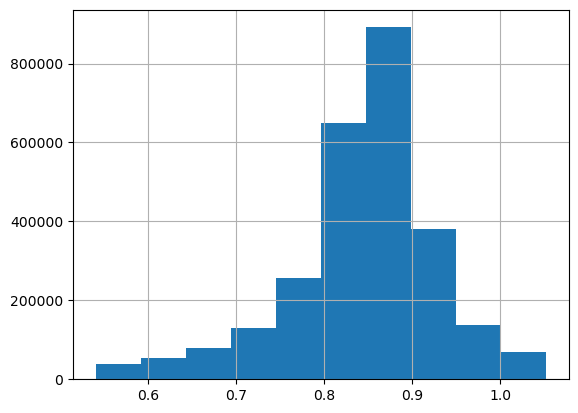

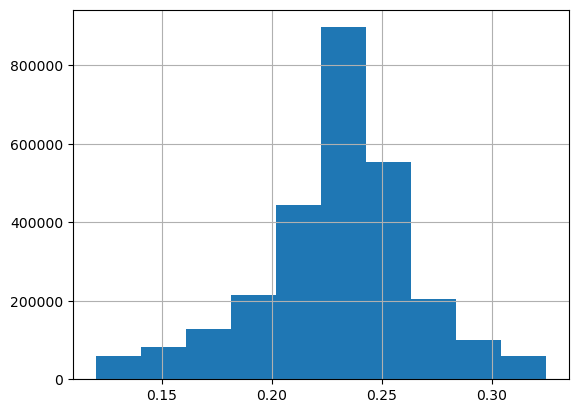

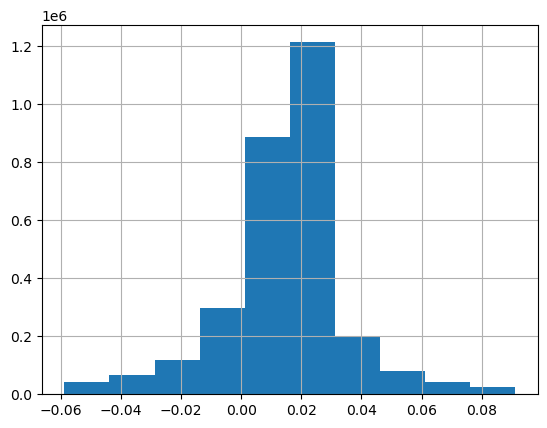

In [7]:
for pid in particles['pid'].unique():
    particles[particles['pid'] == pid]['mass2'].hist()
    plt.show()

In [8]:
# The following columns will be used to predict whether a reconstructed candidate is a lambda particle or not
params = ['mass2', 'p']
x = particles[params].copy()

# The MC information is saved in this y variable
y =pd.DataFrame(particles['pid'], dtype='int')

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=324)
del particles, x, y

#DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed. 
dtrain = xgb.DMatrix(x_train, label = y_train)
# dtest1=xgb.DMatrix(x_test, label = y_test)
# del x_test
gc.collect()

10400

In [9]:
def bo_tune_xgb(max_depth, gamma, alpha,learning_rate):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'alpha':alpha,
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.3,
              'num_class':np.unique(dtrain.get_label()).shape[0],
              'objective':'multi:softprob', 
              'eval_metric': 'mlogloss',
              'tree_method':'hist', 'nthread' : 7}
    cv_result = xgb.cv(params=params, dtrain=dtrain, num_boost_round=10, nfold=5)
    return cv_result['test-mlogloss-mean'].iloc[-1]
# bounds_transformer = SequentialDomainReductionTransformer()
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4, 10),
                                             'alpha': (2,12),
                                             'gamma': (0, 1),
                                             'learning_rate':(0.01,.5),
                                            })



In [10]:
#performing Bayesian optimization for 5 iterations with 8 steps of random exploration with an #acquisition function of expected improvement
xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   |   gamma   | learni... | max_depth |
-------------------------------------------------------------------------
|  1        |  0.9305   |  10.79    |  0.5671   |  0.01254  |  6.823    |
|  2        |  0.01233  |  6.542    |  0.01113  |  0.454    |  7.618    |
|  3        |  0.01124  |  10.66    |  0.9971   |  0.4695   |  9.512    |
|  4        |  0.02311  |  6.377    |  0.5698   |  0.368    |  7.341    |
|  5        |  0.2334   |  10.03    |  0.3932   |  0.1311   |  6.537    |
|  6        |  0.9616   |  11.0     |  0.6127   |  0.01     |  6.896    |
|  7        |  0.9616   |  11.2     |  0.5692   |  0.01     |  6.439    |
|  8        |  0.5137   |  11.29    |  0.0125   |  0.06108  |  6.615    |
|  9        |  0.9616   |  11.05    |  0.9943   |  0.01     |  6.573    |
|  10       |  0.9616   |  11.6     |  1.0      |  0.01     |  5.968    |


In [11]:
print(xgb_bo.max['params'])

{'alpha': 10.995638405516468, 'gamma': 0.612732720238707, 'learning_rate': 0.01, 'max_depth': 6.89616938096525}


In [12]:
# max_param = xgb_bo.max['params']
max_param = {'alpha': 10.995638405516468, 'gamma': 0.612732720238707,
             'learning_rate': 0.01, 'max_depth': 6.89616938096525}
param= {'alpha': max_param['alpha'], 'gamma': max_param['gamma'], 'learning_rate': max_param['learning_rate'],
        'max_depth': int(round(max_param['max_depth'],0)), 'num_class':np.unique(dtrain.get_label()).shape[0],
        'objective':'multi:softprob','eval_metric': 'mlogloss',
        'tree_method':'hist','nthread' : 7}

#Fit/train on training data
bst = xgb.XGBClassifier(**param, use_label_encoder=False).fit(x_train, y_train)

#predicitions on training set
bst_train= pd.DataFrame(data=bst.predict_proba(x_train))
y_train=y_train.set_index(np.arange(0,bst_train.shape[0]))
# bst_train['xgb_preds']=bst_train.iloc[:,0:(len(bst_train.columns)-1)].idxmax(axis = 1)
# bst_train['pid']=y_train['pid']

bst_test = pd.DataFrame(data=bst.predict_proba(x_test))
bst_test['xgb_preds']=bst_test.iloc[:,0:(len(bst_test.columns)-1)].idxmax(axis = 1)
y_test=y_test.set_index(np.arange(0,bst_test.shape[0]))
bst_test['pid']=y_test['pid']

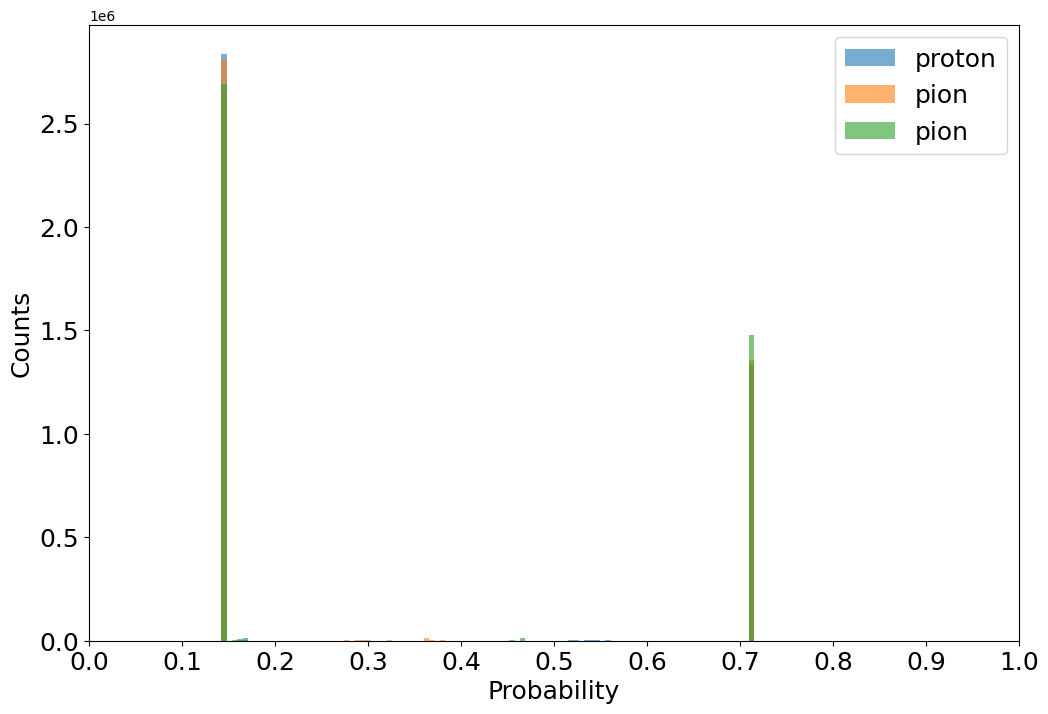

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(bst_test[0], bins = 100, label='proton', alpha = .6) # proton
plt.hist(bst_test[1], bins = 100, label='pion', alpha = .6) # kaon 
plt.hist(bst_test[2], bins = 100, label='pion', alpha = .6) # pion 

ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

## Another set
We also select the selected variables from the 10k events data set

In [33]:
# We import three root files into our jupyter notebook
particlesTest = tree_importer.tree_importer(fileNameTest,'plain_tree',7)
particlesTest.columns = particlesTest.columns.str.replace('Complex_', '')
# bckgr = bckgr[(bckgr['Candidates_generation'] < 1)
#                  & ((bckgr['Candidates_mass'] > lower5SigmaCutBckgr)
#                  & (bckgr['Candidates_mass'] < lower5SigmaCutSign) | (bckgr['Candidates_mass']>upper5SigmaCutSign) 
gc.collect()
#changign to the same pid as in training
particlesTest['pid'] = particlesTest.pid.abs().map(defaultdict(lambda: 4, {Pid.PROTON.value : 0, Pid.KAON.value : 1, Pid.PION.value : 2}),na_action='ignore')
particlesTest.iloc[0:10,:]

,eta,l,mass,mass2,p,pT,phi,px,py,pz,rapidity,t,pid,q
0,2.795109,796.765564,0.139570,0.044752,3.360802,0.409217,-1.931746,-0.144520,-0.382848,3.335796,2.740521,26.631847,2,-1.0
1,2.862100,797.093079,0.493677,0.248146,2.920601,0.332732,-1.740885,-0.056321,-0.327931,2.901586,2.287393,26.975466,1,1.0
2,2.025051,785.335205,0.938272,0.904669,2.650691,0.687733,-2.986821,-0.679512,-0.106017,2.559919,1.529873,27.855837,0,1.0
3,1.962085,745.262451,0.938272,0.842410,3.123042,0.860970,-0.086505,0.857751,-0.074385,3.002019,1.592940,25.919329,0,1.0
4,2.162448,734.718689,0.139570,-0.004009,2.821904,0.640801,0.066599,0.639381,0.042645,2.748184,2.139893,24.501303,2,-1.0
5,3.121445,792.576599,0.938272,1.108287,6.939540,0.610784,1.233429,0.202172,0.576353,6.912608,2.520050,26.742485,0,1.0
6,2.217318,759.005249,0.938272,0.834824,2.472587,0.532222,2.700255,-0.481225,0.227338,2.414628,1.545454,27.027834,0,1.0
7,2.333610,749.677795,0.139570,0.015155,3.696914,0.710121,2.618707,-0.615236,0.354622,3.628071,2.315019,25.072449,2,1.0
8,2.156020,733.076660,0.139570,0.015053,5.610508,1.282038,0.950416,0.745306,1.043139,5.462068,2.150286,24.501919,2,1.0
9,2.211525,769.359009,0.139570,0.018099,1.712385,0.370680,1.318592,0.092499,0.358953,1.671783,2.146911,25.997503,2,1.0


In [34]:
x_whole = particlesTest[params].copy()
y_whole = pd.DataFrame(particlesTest['pid'], dtype='int')

whole_test= pd.DataFrame(data=bst.predict_proba(x_whole))
y_whole=y_whole.set_index(np.arange(0,whole_test.shape[0]))
whole_test['pid']=y_whole['pid']
whole_test['xgb_preds']=whole_test.iloc[:,:(len(whole_test.columns)-1)].idxmax(axis = 1)
gc.collect()

9

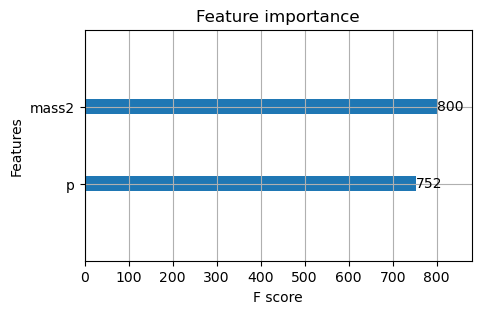

In [35]:
#The following graph will show us that which features are important for the model
ax = xgb.plot_importance(bst)
plt.rcParams['figure.figsize'] = [5, 3]
plt.show()
ax.figure.tight_layout() 
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.pdf')
# ax.figure.savefig(directory+'img/xgb_12agev/chi2geo/feature_importance.png')

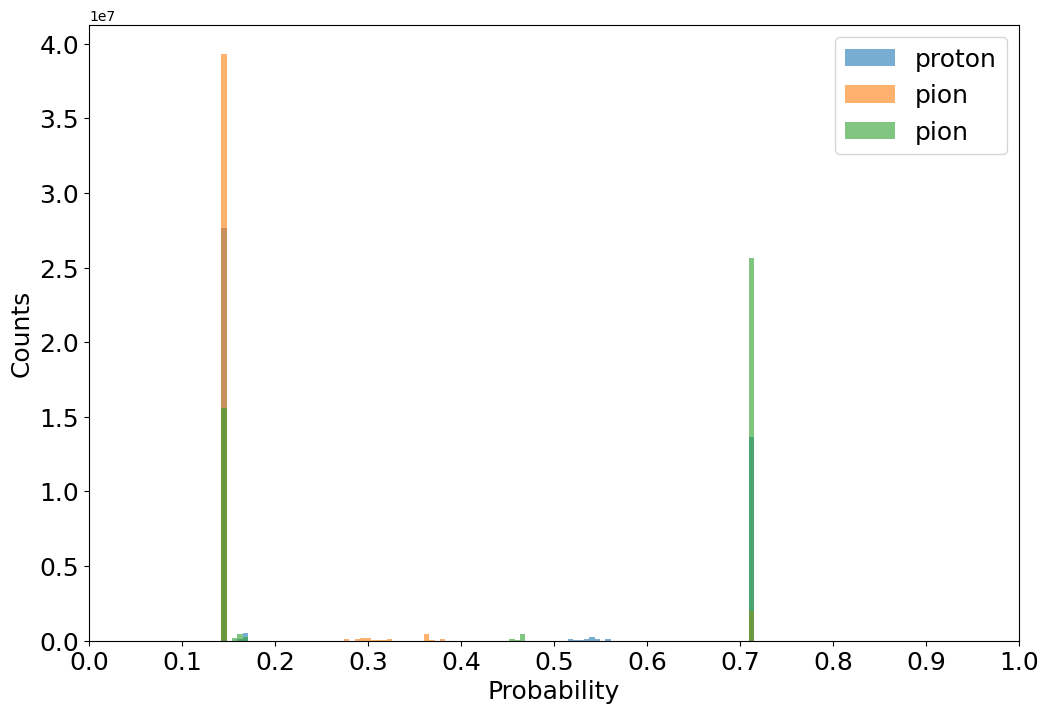

In [37]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.hist(whole_test[0], bins = 100, label='proton', alpha = .6) # proton
plt.hist(whole_test[1], bins = 100, label='pion', alpha = .6) # kaon 
plt.hist(whole_test[2], bins = 100, label='pion', alpha = .6) # pion 

ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=18)
plt.show()

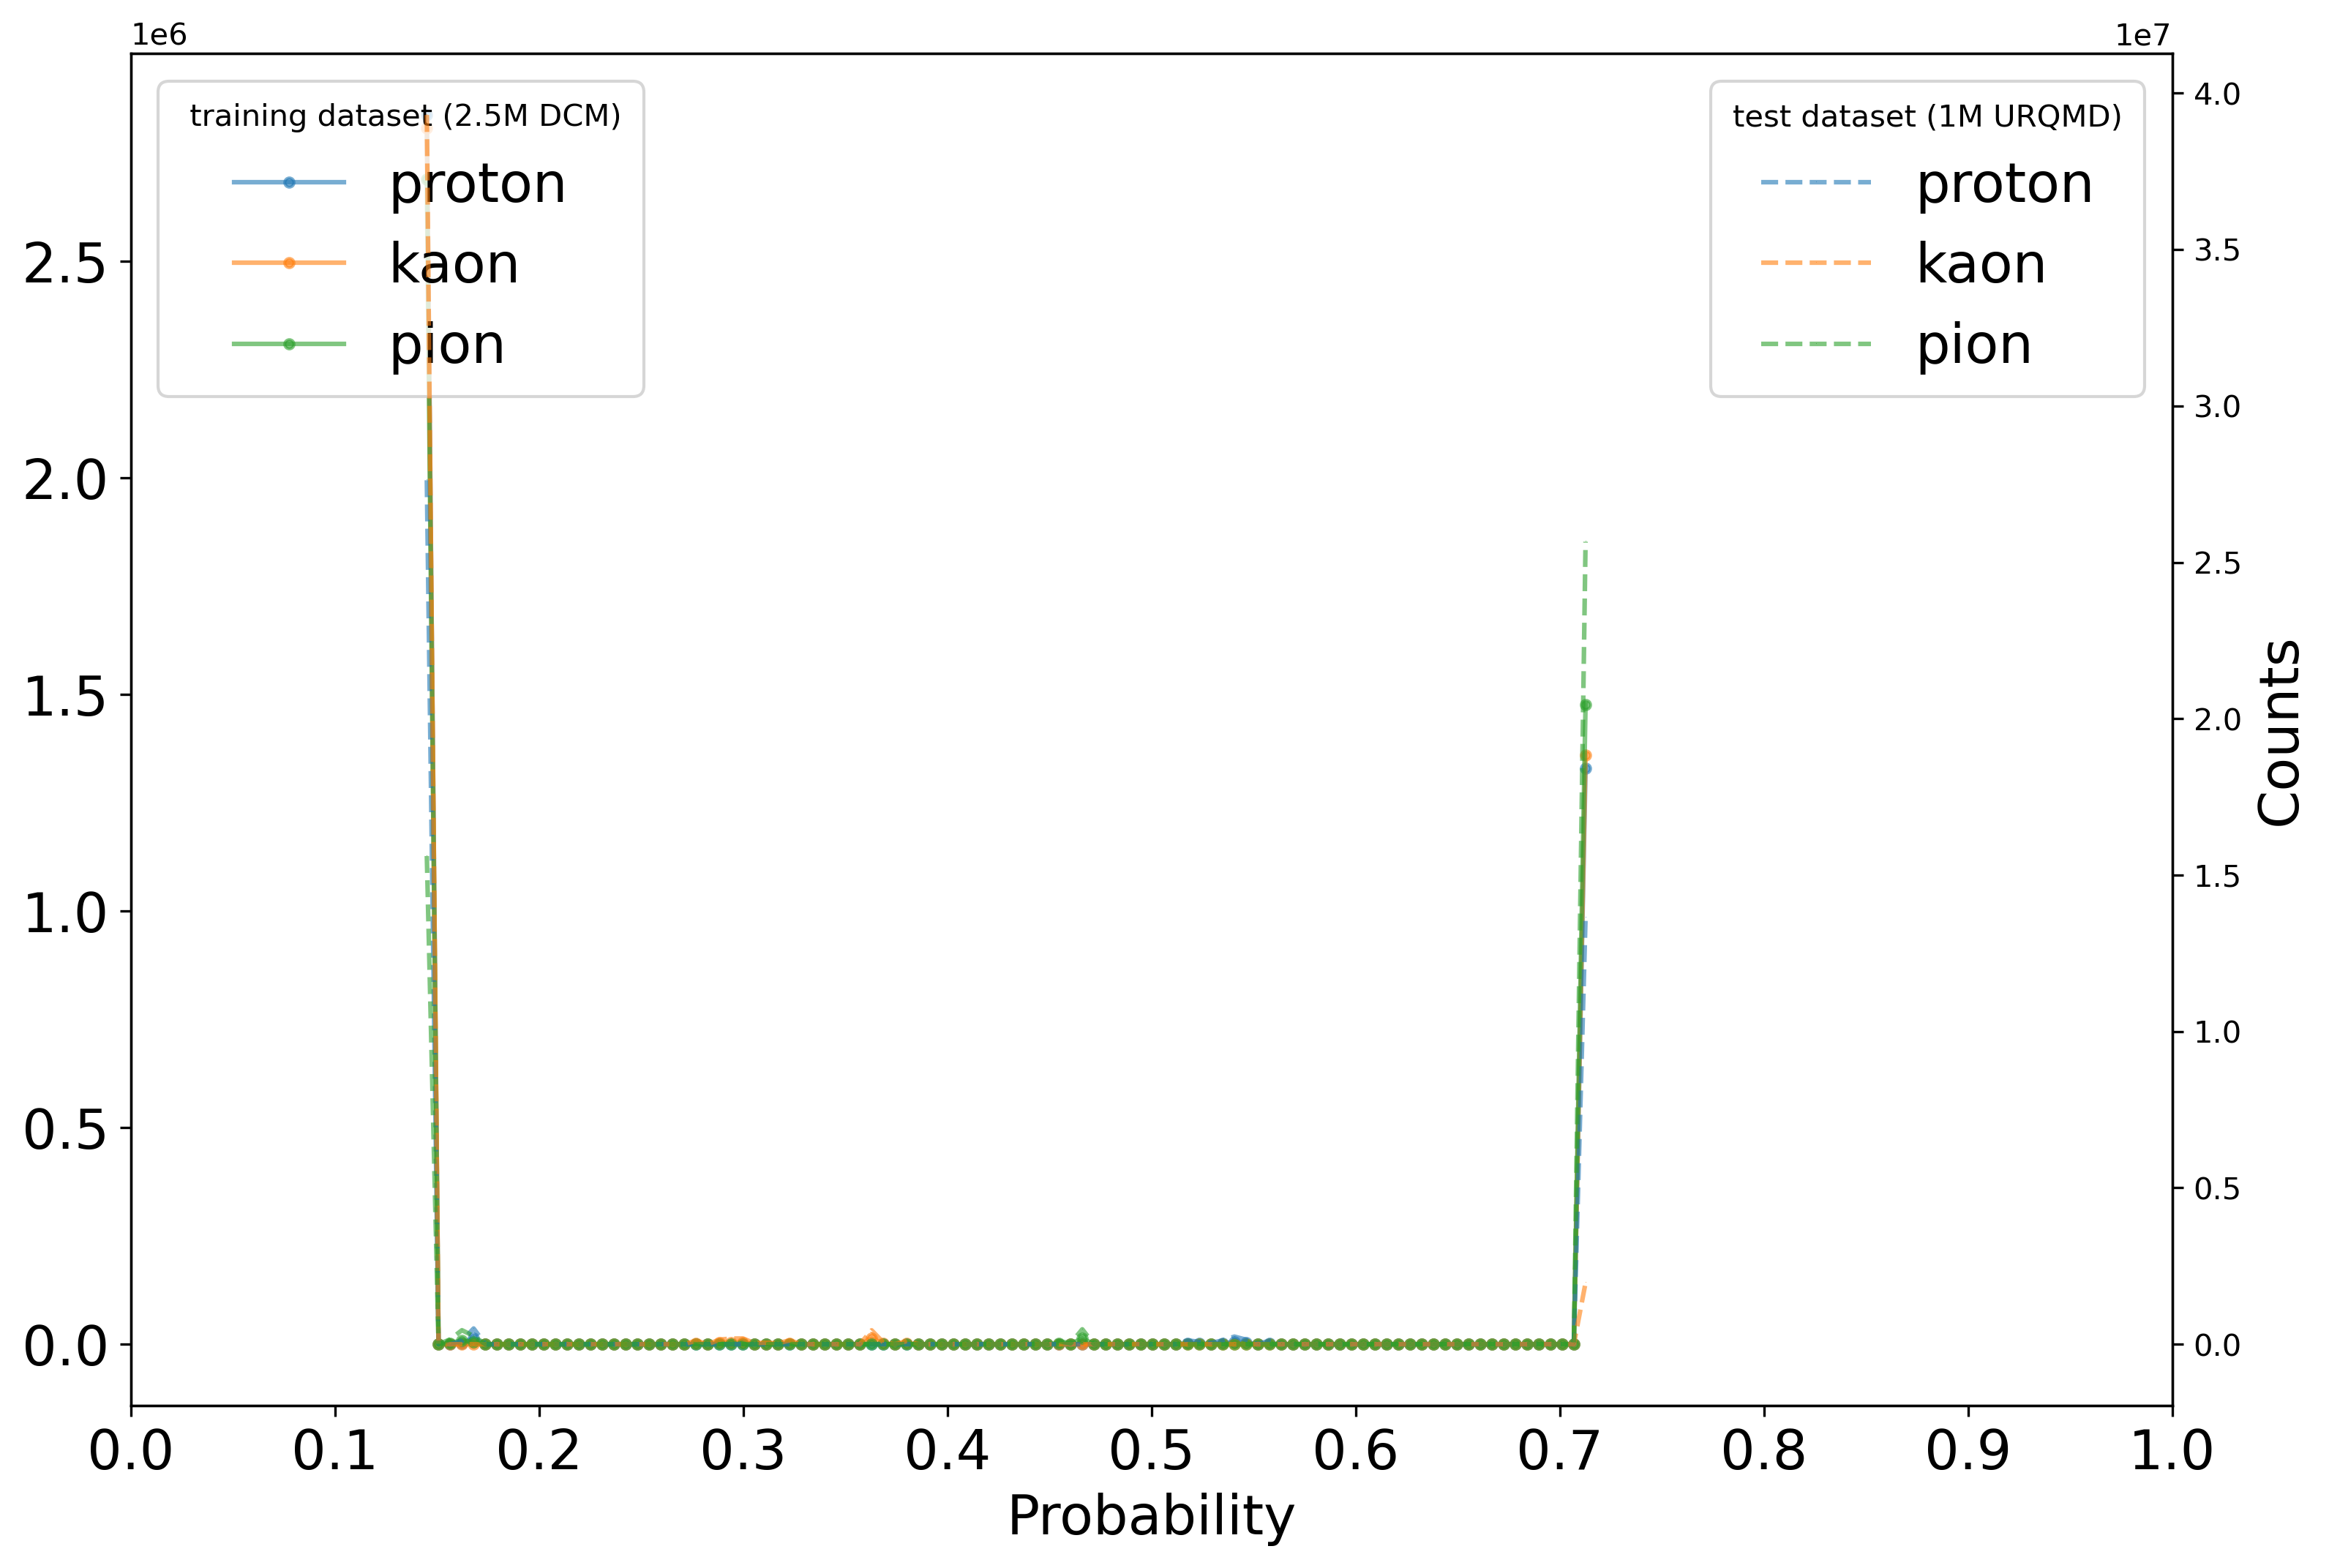

In [36]:
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)

ax2 = ax.twinx()

def subplot(df1, df2, i, label):
    counts, bin_edges = np.histogram(df1[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax.plot(bin_centers, counts, label=label, alpha = .6, marker='.')
    # ax.hist(df1[i], bins = 100, alpha = .6) 
    
    counts, bin_edges = np.histogram(df2[i],bins = 100)
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
    ax2.plot(bin_centers, counts, label=label, alpha = .6, marker=',', linestyle='dashed')
    # ax.hist(df2[i], bins = 100, alpha = .6) 
    
subplot(bst_train, whole_test, 0, 'proton') 
# subplot(bst_train, whole_test, 1, 'pion')
subplot(bst_train, whole_test, 1, 'kaon')
subplot(bst_train, whole_test, 2, 'pion')
# subplot(bst_train, whole_test, 3, 'ghost')
ax.legend(title= ' training dataset (2.5M DCM)', fontsize = 18, loc='upper left')
ax2.legend(title= 'test dataset (1M URQMD)',fontsize = 18,loc='upper right' )
ax.set_xlabel('Probability',fontsize=18)
plt.ylabel('Counts', fontsize=18)
ax.set_xticks(np.arange(0,1.1,0.1))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)

# ax.text(0.51, 220000, r'DCM-QGSM-SMM, Au+Au @12 $A$GeV/$c$; 2.5M events', fontsize=16, color = 'black')
# ax2.text(0.52, 35000, r'URQMD, Au+Au @12 $A$GeV/$c$; 1M events', fontsize=16, color = 'black')
plt.show()

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize = 15)
    plt.xlabel('Predicted label',fontsize = 15)

Confusion matrix, without normalization
[[13099678   276326   680185        0]
 [  104502  1110446   170430        0]
 [  203393   351526 19998371        0]
 [ 1103108   227813  5415715        0]]


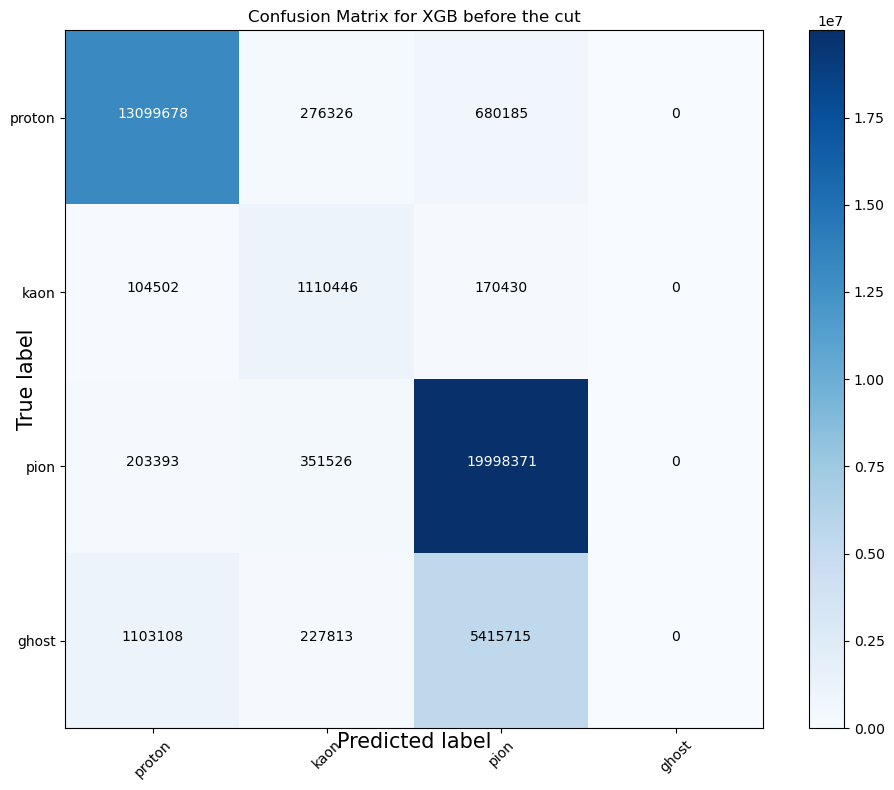

In [18]:

classes = ['proton', 'kaon', 'pion', 'ghost']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion Matrix for XGB before the cut', normalize=False)
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

In [28]:
#cut on probability
whole_test = whole_test.drop(columns=['xgb_preds'])
proba = .3
whole_test = whole_test[ whole_test[[0, 2]].max(axis = 1) > proba]
whole_test['xgb_preds']=whole_test.iloc[:,:(len(whole_test.columns)-1)].idxmax(axis = 1)

In [29]:
whole_test

,0,1,2,pid,xgb_preds


In [24]:

classes = ['proton', 'kaon', 'pion', 'ghost']
# for particle in Pid:
#     classes.append(str(particle).replace('Pid.', ''))
np.set_printoptions(precision=2)
cnf_matrix = confusion_matrix(whole_test['pid'], whole_test['xgb_preds'])#, labels=[1,0])
np.set_printoptions(precision=2)
fig, axs = plt.subplots(figsize=(10, 8))
axs.yaxis.set_label_coords(-0.04,.5)
axs.xaxis.set_label_coords(0.5,-.005)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion Matrix for XGB after the cut', normalize=False)
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.pdf')
# fig.savefig(directory+'img/xgb_12agev/chi2geo/confusion_matrix_extreme_gradient_boosting_whole_data.png')
plt.show()

Confusion matrix, without normalization
[]


<ipython-input-17-3ffb2a720156>:13: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
<ipython-input-17-3ffb2a720156>:13: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  plt.imshow(cm, interpolation='nearest', cmap=cmap)


ValueError: zero-size array to reduction operation maximum which has no identity